# Import Libraries

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline, SVD
from surprise.model_selection import GridSearchCV
from surprise.similarities import pearson
from surprise import accuracy

# Obtain Data

Read recommender system data from csv file into df

In [2]:
df = pd.read_csv('Data/ratings.csv')
df.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


# Scrub Data

Perform df.info to check df column datatypes

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 4 columns):
userId       int64
movieId      int64
rating       float64
timestamp    int64
dtypes: float64(1), int64(3)
memory usage: 762.9 MB


Check for missing values by calculating df entries by column

In [4]:
for col in df.columns:
    print(f'{col} Datapoints:', len(df[col].values))

userId Datapoints: 25000095
movieId Datapoints: 25000095
rating Datapoints: 25000095
timestamp Datapoints: 25000095


Check for abnormal values in dataset

In [5]:
print('userId Values:')
print(df.groupby('userId').first().index.sort_values())
print()
print('movieId Values:')
print(df.groupby('movieId').first().index.sort_values())
print()
print('rating Value Counts:')
print(df['rating'].value_counts())

userId Values:
Int64Index([     1,      2,      3,      4,      5,      6,      7,      8,
                 9,     10,
            ...
            162532, 162533, 162534, 162535, 162536, 162537, 162538, 162539,
            162540, 162541],
           dtype='int64', name='userId', length=162541)

movieId Values:
Int64Index([     1,      2,      3,      4,      5,      6,      7,      8,
                 9,     10,
            ...
            209145, 209147, 209151, 209153, 209155, 209157, 209159, 209163,
            209169, 209171],
           dtype='int64', name='movieId', length=59047)

rating Value Counts:
4.0    6639798
3.0    4896928
5.0    3612474
3.5    3177318
4.5    2200539
2.0    1640868
2.5    1262797
1.0     776815
1.5     399490
0.5     393068
Name: rating, dtype: int64


Multiply movie ratings by 2 to have ratings consist soley of whole numbers

In [6]:
df['rating'] = df['rating'].apply(lambda x: 2*x)
df['rating'].value_counts()

8.0     6639798
6.0     4896928
10.0    3612474
7.0     3177318
9.0     2200539
4.0     1640868
5.0     1262797
2.0      776815
3.0      399490
1.0      393068
Name: rating, dtype: int64

Save scrubbed df to csv file

In [18]:
df.to_csv('Data/scrubbed_ratings.csv', index=False)

# Explore Data

Calculate descriptive statistics for movie ratings

In [7]:
df[['rating']].describe().style.format("{:,.2f}")

,rating
count,"25,000,095.00"
mean,7.07
std,2.12
min,1.00
25%,6.00
50%,7.00
75%,8.00
max,10.00


Plot distribution of movie ratings

Text(0, 0.5, 'Count')

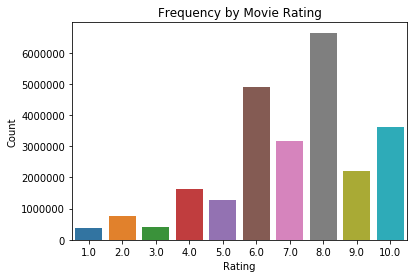

In [8]:
fig, ax = plt.subplots()
sns.countplot(x='rating', data=df, ax=ax)
ax.set_title('Frequency by Movie Rating')
ax.set_xlabel('Rating')
ax.set_ylabel('Count')

Plot distribution of movie ratings with histogram

Text(0, 0.5, 'Relative Frequency')

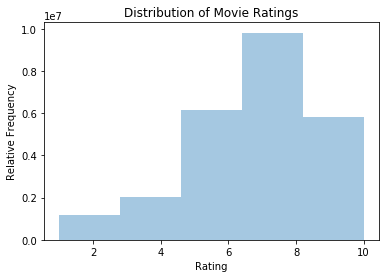

In [9]:
fig, ax = plt.subplots()
sns.distplot(df['rating'], bins=5, kde=False, ax=ax)
ax.set_title('Distribution of Movie Ratings')
ax.set_xlabel('Rating')
ax.set_ylabel('Relative Frequency')

Calculate descriptive statistics for number of ratings by user

In [10]:
user_df = df.groupby('userId').count()
user_df[['rating']].describe()

,rating
count,162541.000000
mean,153.807932
std,268.047590
min,20.000000
25%,36.000000
50%,71.000000
75%,162.000000
max,32202.000000


Plot distribution for number of movie ratings by user

Text(0, 0.5, 'Count')

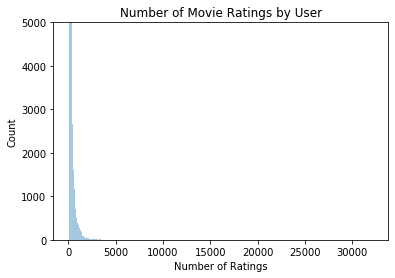

In [11]:
fig, ax = plt.subplots()
sns.distplot(user_df['rating'], bins=500, kde=False, ax=ax)
ax.set_title('Number of Movie Ratings by User')
ax.set_xlabel('Number of Ratings')
ax.set_ylim([0,5000])
ax.set_ylabel('Count')

Plot boxplot for number of movie ratings by user

Text(0, 0.5, 'Number of Movie Ratings')

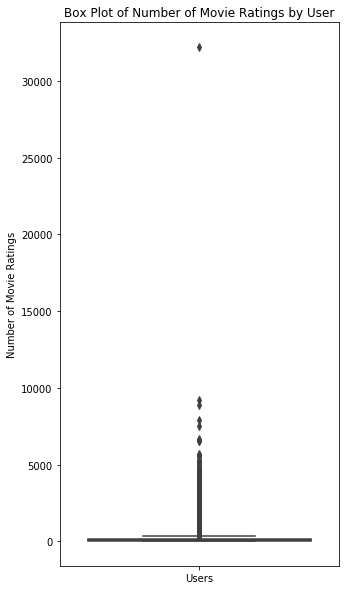

In [12]:
fig, ax = plt.subplots(figsize=(5,10))
sns.boxplot(y='rating', data=user_df, ax=ax)
ax.set_title('Box Plot of Number of Movie Ratings by User')
ax.set_xticklabels(['Users'])
ax.set_ylabel('Number of Movie Ratings')

Calculate descriptive statistics for number of ratings by movie

In [13]:
movie_df = df.groupby('movieId').count()
movie_df['rating'].describe()

count    59047.000000
mean       423.393144
std       2477.885821
min          1.000000
25%          2.000000
50%          6.000000
75%         36.000000
max      81491.000000
Name: rating, dtype: float64

Plot distribution for number of ratings by movie

Text(0, 0.5, 'Count')

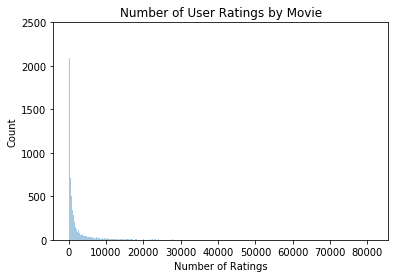

In [14]:
fig, ax = plt.subplots()
sns.distplot(movie_df['rating'], bins=500, kde=False, ax=ax)
ax.set_title('Number of User Ratings by Movie')
ax.set_xlabel('Number of Ratings')
ax.set_ylim([0,2500])
ax.set_ylabel('Count')

Plot boxplot for number of user ratings by movie

Text(0, 0.5, 'Number of User Ratings')

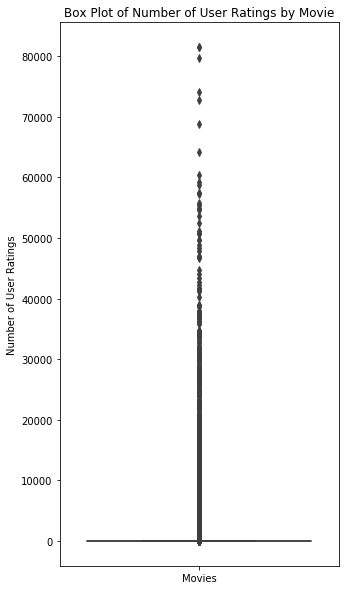

In [15]:
fig, ax = plt.subplots(figsize=(5,10))
sns.boxplot(y='rating', data=movie_df, ax=ax)
ax.set_title('Box Plot of Number of User Ratings by Movie')
ax.set_xticklabels(['Movies'])
ax.set_ylabel('Number of User Ratings')

# Model Data

Load movie review data into surprise

In [22]:
reader = Reader(rating_scale=(1,10), line_format='user item rating timestamp', 
                sep = ',',skip_lines=1)
dataset = Dataset.load_from_file('Data/scrubbed_ratings.csv', reader)
trainset, testset = train_test_split(dataset, test_size=0.2, random_state = 34)

Build and evaluate baseline model

In [32]:
baseline_df = pd.read_csv('Data/scrubbed_ratings.csv')
baseline_pred = np.array([baseline_df['rating'].mean()]*len(baseline_df['rating']))
actuals = np.array(baseline_df['rating'])
baseline_rmse = sqrt(mean_squared_error(actuals, baseline_pred))
baseline_mae =  mean_absolute_error(actuals, baseline_pred)
print('MAE: ', baseline_mae)
print('RMSE: ', baseline_rmse)

MAE:  1.6828041518708374
RMSE:  2.1214878798551062


Build and evaluate KNN recommender system model

In [ ]:
knn = KNNBasic(k=10, verbose = True)
knn.fit(trainset)
knn_predictions = knn.test(testset)
accuracy.mae(knn_predictions)
accuracy.rmse(knn_predictions)

Build and evaluate SVD recommender system model

In [ ]:
svd = SVD(n_factors=10, n_epochs=10, verbose = True)
svd.fit(trainset)
svd_predictions = svd.test(testset)
accuracy.mae(svd_predictions)
accuracy.rmse(svd_predictions)